In [2]:
import os
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
from torch.autograd import Variable as V
import types
import numpy as np


In [12]:
import torch
import torchvision.models as models

def get_moco_model():
    model = models.resnet50()
    model.fc = torch.nn.Identity()  
    return model

In [13]:
moco_model = get_moco_model()

checkpoint = torch.load('moco_v2_800ep_pretrain.pth.tar', map_location='cpu')

state_dict = checkpoint['state_dict']  
state_dict = {k.replace("module.encoder_q.", ""): v for k, v in state_dict.items()} 

moco_model.load_state_dict(state_dict, strict=False)
moco_model.eval() 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [15]:
import os
img_set_dir = '/Users/parthsandeep/moco/training_images'
img_partitions = os.listdir(img_set_dir)

In [16]:
from torch.autograd import Variable as V

In [17]:
moco_model.feat_list = ['layer1' 'fc']

# Define custom forward method
def reduced_forward(self, x):
    # First layer
    first_layer_output = self.conv1(x)
    first_layer_output = self.bn1(first_layer_output)
    first_layer_output = self.relu(first_layer_output)

    # Continue through the rest of the network
    x = self.maxpool(first_layer_output)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    # Last layer
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    last_layer_output = self.fc(x)

    return first_layer_output, last_layer_output

# Attach custom forward to the model
moco_model.reduced_forward = types.MethodType(reduced_forward, moco_model)

In [8]:
img_partitions = os.listdir(img_set_dir)

img_set_dir = '/Users/parthsandeep/moco/training_images'

# Output directory to save features
save_dir = '/Users/parthsandeep/moco/reduced_feature_maps'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Loop through all image partitions (e.g., train, test, validation)
img_partitions = os.listdir(img_set_dir)
for p in img_partitions:
    part_dir = os.path.join(img_set_dir, p)
    image_list = []
    for root, dirs, files in os.walk(part_dir):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".JPEG"):
                image_list.append(os.path.join(root, file))
    image_list.sort()

    # Create partition save directory
    partition_save_dir = os.path.join(save_dir, p)
    if not os.path.exists(partition_save_dir):
        os.makedirs(partition_save_dir)

    # Process each image
    for i, image_path in enumerate(image_list):
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        input_img = preprocess(img).unsqueeze(0)  # Add batch dimension
        if torch.cuda.is_available():
            input_img = input_img.cuda()

        # Extract features from first and last layers
        first_layer, last_layer = moco_model.reduced_forward(input_img)

        # Flatten and save features
        feats = {
            "first_layer": first_layer.data.cpu().numpy().flatten(),  # Flatten first layer features
            "last_layer": last_layer.data.cpu().numpy().flatten()     # Flatten last layer features
        }

        # Save feature map
        file_name = f"{p}_{i+1:07d}.npy"
        file_path = os.path.join(partition_save_dir, file_name)
        np.save(file_path, feats)

        print(f"Saved features for {image_path} as {file_name}")

Saved features for /Users/parthsandeep/moco/training_images/00204_button2/button2_01b.jpg as 00204_button2_0000001.npy
Saved features for /Users/parthsandeep/moco/training_images/00204_button2/button2_02s.jpg as 00204_button2_0000002.npy
Saved features for /Users/parthsandeep/moco/training_images/00204_button2/button2_03s.jpg as 00204_button2_0000003.npy
Saved features for /Users/parthsandeep/moco/training_images/00204_button2/button2_04s.jpg as 00204_button2_0000004.npy
Saved features for /Users/parthsandeep/moco/training_images/00204_button2/button2_05s.jpg as 00204_button2_0000005.npy
Saved features for /Users/parthsandeep/moco/training_images/00204_button2/button2_06s.jpg as 00204_button2_0000006.npy
Saved features for /Users/parthsandeep/moco/training_images/00204_button2/button2_07s.jpg as 00204_button2_0000007.npy
Saved features for /Users/parthsandeep/moco/training_images/00204_button2/button2_08s.jpg as 00204_button2_0000008.npy
Saved features for /Users/parthsandeep/moco/trai

In [19]:
from sklearn.decomposition import IncrementalPCA

feature_dir = '/Users/parthsandeep/moco/reduced_feature_maps/'
output_dir = '/Users/parthsandeep/moco/pca_batches/'
batch_size = 100  # Adjust based on your computer's capacity
n_components = 100  # Number of PCA components

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Incremental PCA
pca_first = IncrementalPCA(n_components=n_components)
pca_last = IncrementalPCA(n_components=n_components)

# Prepare file list
all_files = []
for root, _, files in os.walk(feature_dir):
    for file_name in files:
        if file_name.endswith('.npy'):
            all_files.append(os.path.join(root, file_name))

all_files = sorted(all_files)  # Ensure order

In [22]:
import joblib

for i in range(0, len(all_files), batch_size):
    batch_files = all_files[i:i + batch_size]
    batch_first_layer = []
    batch_last_layer = []

    for file_path in batch_files:
        feats = np.load(file_path, allow_pickle=True).item()
        batch_first_layer.append(feats['first_layer'])
        batch_last_layer.append(feats['last_layer'])

    batch_first_layer = np.array(batch_first_layer)
    batch_last_layer = np.array(batch_last_layer)

    # Handle smaller last batch
    if batch_first_layer.shape[0] < n_components:
        print(f"Skipping last batch of size {batch_first_layer.shape[0]} (too small for PCA).")
        break

    # Incrementally fit PCA
    pca_first.partial_fit(batch_first_layer)
    pca_last.partial_fit(batch_last_layer)

    # Transform and save reduced features
    reduced_first = pca_first.transform(batch_first_layer)
    reduced_last = pca_last.transform(batch_last_layer)

    np.save(os.path.join(output_dir, f"batch_{i // batch_size + 1}_first.npy"), reduced_first)
    np.save(os.path.join(output_dir, f"batch_{i // batch_size + 1}_last.npy"), reduced_last)

    print(f"Processed and saved batch {i // batch_size + 1}/{len(all_files) // batch_size + 1}")

# Save PCA models
joblib.dump(pca_first, os.path.join(output_dir, 'pca_first_model.joblib'))
joblib.dump(pca_last, os.path.join(output_dir, 'pca_last_model.joblib'))
print("PCA models and reduced features saved successfully.")

Processed and saved batch 1/166
Processed and saved batch 2/166
Processed and saved batch 3/166
Processed and saved batch 4/166
Processed and saved batch 5/166
Processed and saved batch 6/166
Processed and saved batch 7/166
Processed and saved batch 8/166
Processed and saved batch 9/166
Processed and saved batch 10/166
Processed and saved batch 11/166
Processed and saved batch 12/166
Processed and saved batch 13/166
Processed and saved batch 14/166
Processed and saved batch 15/166
Processed and saved batch 16/166
Processed and saved batch 17/166
Processed and saved batch 18/166
Processed and saved batch 19/166
Processed and saved batch 20/166
Processed and saved batch 21/166
Processed and saved batch 22/166
Processed and saved batch 23/166
Processed and saved batch 24/166
Processed and saved batch 25/166
Processed and saved batch 26/166
Processed and saved batch 27/166
Processed and saved batch 28/166
Processed and saved batch 29/166
Processed and saved batch 30/166
Processed and saved

In [22]:
eeg_data = np.load("/Users/parthsandeep/moco/EEGNPY/eeg_training01.npy",  allow_pickle=True)

eeg_signals = data_dict['preprocessed_eeg_data']
ch_names = data_dict['ch_names']
times = data_dict['times']

if isinstance(eeg_data, np.ndarray):
    data_dict = eeg_data.item()  
    print(type(data_dict))       
    print(data_dict.keys()) 

print(f"EEG signals shape: {eeg_signals.shape}")
print(f"Channel names: {ch_names}")
print(f"Times shape: {times.shape}, Times: {times[:5]}")

<class 'dict'>
dict_keys(['preprocessed_eeg_data', 'ch_names', 'times'])
EEG signals shape: (16540, 4, 17, 100)
Channel names: ['Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
Times shape: (100,), Times: [-0.2  -0.19 -0.18 -0.17 -0.16]


In [17]:
eeg_signals_mean = eeg_signals.mean(axis=1)  # Shape becomes (16540, 17, 100)
print(f"After averaging: {eeg_signals_mean.shape}")

After averaging: (16540, 17, 100)


In [18]:
flattened_signals = eeg_signals_mean.reshape(eeg_signals_mean.shape[0], -1)  # Shape (16540, 1700)
print(f"Flattened EEG signals: {flattened_signals.shape}")

Flattened EEG signals: (16540, 1700)


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_signals = scaler.fit_transform(flattened_signals)
print(f"Normalized signals shape: {normalized_signals.shape}")

Normalized signals shape: (16540, 1700)


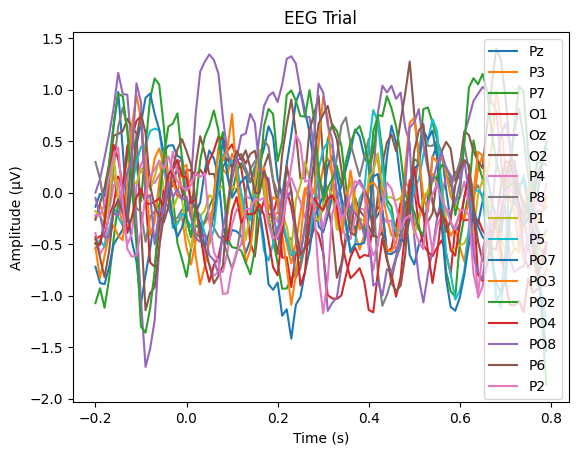

In [21]:
import matplotlib.pyplot as plt

trial = eeg_signals_mean[0]  # First trial
for i, channel in enumerate(ch_names):
    plt.plot(times, trial[i], label=channel)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("EEG Trial")
plt.legend()
plt.show()

In [24]:
from sklearn.decomposition import PCA
eeg_signals = eeg_signals[:16500]
eeg_signals_reshaped = eeg_signals.reshape(eeg_signals.shape[0], -1)  # Flatten EEG
pca = PCA(n_components=10)  # Choose number of components
eeg_pca = pca.fit_transform(eeg_signals_reshaped)

print(f"PCA-transformed EEG shape: {eeg_pca.shape}")  # (16540, 10)

PCA-transformed EEG shape: (16500, 10)


In [28]:
pca_batches = [np.load(f"/Users/parthsandeep/moco/pca_batches/batch_{i}_first.npy") for i in range(1, 166)]  # Modify filenames

# Concatenate into a single matrix
image_pca = np.vstack(pca_batches)

print(f"Combined PCA shape: {image_pca.shape}") 

Combined PCA shape: (16500, 100)


In [29]:
if eeg_signals.shape[0] != image_pca.shape[0]:
    raise ValueError("Mismatch between EEG trials and PCA rows!")

In [30]:
eeg_signals_flat = eeg_signals.reshape(eeg_signals.shape[0], -1)  # Flatten EEG
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
eeg_signals_scaled = scaler.fit_transform(eeg_signals_flat)

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(eeg_signals_scaled, image_pca)  # Predict image PCAs from EEG signals

print(f"Model R-squared: {model.score(eeg_signals_scaled, image_pca):.4f}")

Model R-squared: 0.4386


(16500, 100)


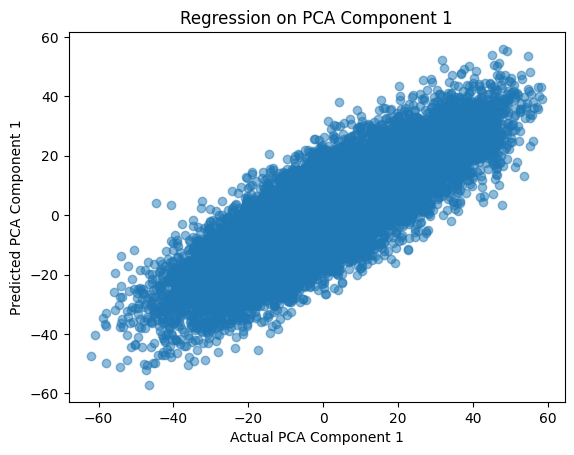

In [32]:
predictions = model.predict(eeg_signals_scaled)
print(predictions.shape)  # Should match the shape of `image_pca`

# Visualize one PCA component
import matplotlib.pyplot as plt
plt.scatter(image_pca[:, 0], predictions[:, 0], alpha=0.5)
plt.xlabel("Actual PCA Component 1")
plt.ylabel("Predicted PCA Component 1")
plt.title("Regression on PCA Component 1")
plt.show()

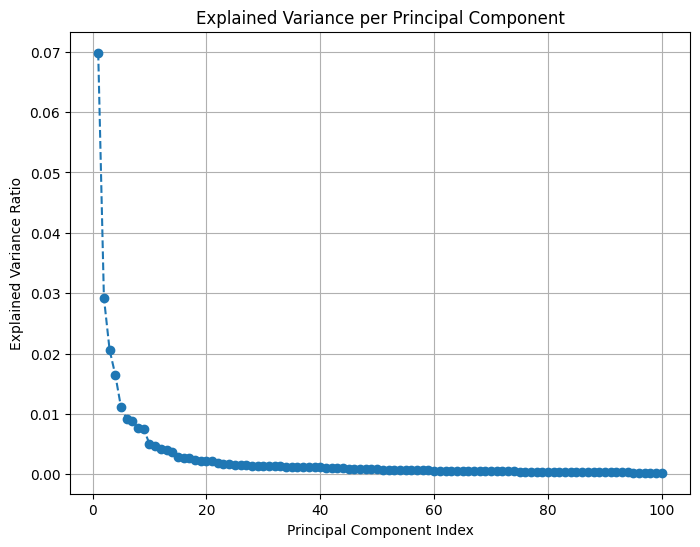

In [3]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
pca = joblib.load('/Users/parthsandeep/moco/pca_batches/pca_first_model.joblib')

# Check if the model has the `explained_variance_ratio_` attribute
if hasattr(pca, 'explained_variance_ratio_'):
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(
        np.arange(1, len(explained_variance_ratio) + 1),
        explained_variance_ratio,
        marker='o',
        linestyle='--'
    )
    plt.title("Explained Variance per Principal Component")
    plt.xlabel("Principal Component Index")
    plt.ylabel("Explained Variance Ratio")
    plt.grid(True)
    plt.show()
else:
    print("The loaded model does not have an 'explained_variance_ratio_' attribute.")